# Datathon Production EDA Lab
Deep-dive exploratory analysis to uncover predictive signals, diagnose dataset issues, and ideate new features for CatBoost upgrades.

## 1. Environment Setup & Data Loading
Import essentials, configure pandas display, and load the train/test/sample CSVs using the provided semicolon separator.

In [1]:
from pathlib import Path
import json
import math
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from scipy.stats import skew, kurtosis, zscore, ks_2samp

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)
sns.set_theme(style="whitegrid")

DATA_DIR = Path("../data").resolve()
TRAIN_PATH = DATA_DIR / "train.csv"
TEST_PATH = DATA_DIR / "test.csv"
SAMPLE_SUB_PATH = DATA_DIR / "sample_submission.csv"

def load_csv(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path, sep=";")
    df = df.loc[:, ~df.columns.str.contains("^Unnamed")]
    return df

train_df = load_csv(TRAIN_PATH)
test_df = load_csv(TEST_PATH)
sample_submission = load_csv(SAMPLE_SUB_PATH) if SAMPLE_SUB_PATH.exists() else None

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
if sample_submission is not None:
    print(f"Sample submission shape: {sample_submission.shape}")

display(train_df.head())

Train shape: (95339, 33)
Test shape: (2250, 28)
Sample submission shape: (2250, 1)


,ID,id_season,aggregated_family,family,category,fabric,color_name,color_rgb,image_embedding,length_type,silhouette_type,waist_type,neck_lapel_type,sleeve_length_type,heel_shape_type,toecap_type,woven_structure,knit_structure,print_type,archetype,moment,phase_in,phase_out,life_cycle_length,num_stores,num_sizes,has_plus_sizes,price,year,num_week_iso,weekly_sales,weekly_demand,Production
0,1,86,Dresses and jumpsuits,Dresses,"Dresses, jumpsuits and Complete set",WOVEN,AMARILLO,"255,215,0","0.072266474,-0.12752205,0.6080948,-1.2579741,-...",Long,Evase,NaN,V-Neck,Fine Strap,NaN,NaN,Light,NaN,Sin Estampado,NaN,TIME OFF,02/01/2023,26/03/2023,12,152,5,False,35.99,2023,1,66,69,4556
1,1,86,Dresses and jumpsuits,Dresses,"Dresses, jumpsuits and Complete set",WOVEN,AMARILLO,"255,215,0","0.072266474,-0.12752205,0.6080948,-1.2579741,-...",Long,Evase,NaN,V-Neck,Fine Strap,NaN,NaN,Light,NaN,Sin Estampado,NaN,TIME OFF,02/01/2023,26/03/2023,12,152,5,False,35.99,2023,2,112,112,4556
2,1,86,Dresses and jumpsuits,Dresses,"Dresses, jumpsuits and Complete set",WOVEN,AMARILLO,"255,215,0","0.072266474,-0.12752205,0.6080948,-1.2579741,-...",Long,Evase,NaN,V-Neck,Fine Strap,NaN,NaN,Light,NaN,Sin Estampado,NaN,TIME OFF,02/01/2023,26/03/2023,12,152,5,False,35.99,2023,3,135,135,4556
3,1,86,Dresses and jumpsuits,Dresses,"Dresses, jumpsuits and Complete set",WOVEN,AMARILLO,"255,215,0","0.072266474,-0.12752205,0.6080948,-1.2579741,-...",Long,Evase,NaN,V-Neck,Fine Strap,NaN,NaN,Light,NaN,Sin Estampado,NaN,TIME OFF,02/01/2023,26/03/2023,12,152,5,False,35.99,2023,4,99,99,4556
4,1,86,Dresses and jumpsuits,Dresses,"Dresses, jumpsuits and Complete set",WOVEN,AMARILLO,"255,215,0","0.072266474,-0.12752205,0.6080948,-1.2579741,-...",Long,Evase,NaN,V-Neck,Fine Strap,NaN,NaN,Light,NaN,Sin Estampado,NaN,TIME OFF,02/01/2023,26/03/2023,12,152,5,False,35.99,2023,5,74,74,4556


## 2. Schema Validation & Missingness Profiling
Validate expected columns/dtypes, check duplicate IDs, and visualize missingness to uncover data quality issues.

In [2]:
expected_min_columns = {
    "ID",
    "Production",
    "phase_in",
    "phase_out",
    "color_rgb",
    "image_embedding",
    "num_stores",
    "num_sizes",
    "weekly_demand",
}

missing_expected = expected_min_columns - set(train_df.columns)
if missing_expected:
    print("⚠️ Missing expected columns:", missing_expected)
else:
    print("✅ All expected baseline columns present.")

train_dupe_ids = train_df["ID"].duplicated().sum() if "ID" in train_df.columns else 0
test_dupe_ids = test_df["ID"].duplicated().sum() if "ID" in test_df.columns else 0
print(f"Duplicate train IDs: {train_dupe_ids}")
print(f"Duplicate test IDs: {test_dupe_ids}")

schema_summary = pd.DataFrame({
    "column": train_df.columns,
    "dtype": train_df.dtypes.astype(str),
    "train_missing_pct": train_df.isna().mean().values * 100,
    "test_missing_pct": train_df.columns.map(lambda c: test_df[c].isna().mean() * 100 if c in test_df.columns else np.nan),
})
schema_summary.head(20)

✅ All expected baseline columns present.
Duplicate train IDs: 85496
Duplicate test IDs: 0


,column,dtype,train_missing_pct,test_missing_pct
ID,ID,int64,0.000000,0.000000
id_season,id_season,int64,0.000000,0.000000
aggregated_family,aggregated_family,object,0.000000,0.000000
family,family,object,0.000000,0.000000
category,category,object,0.000000,0.000000
fabric,fabric,object,0.000000,0.000000
color_name,color_name,object,0.000000,0.000000
color_rgb,color_rgb,object,0.000000,0.000000
image_embedding,image_embedding,object,0.000000,0.000000
length_type,length_type,object,8.924994,16.977778


C:\Users\sterr\AppData\Local\Temp\ipykernel_33352\346430659.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_pct.values, y=missing_pct.index, palette="rocket")


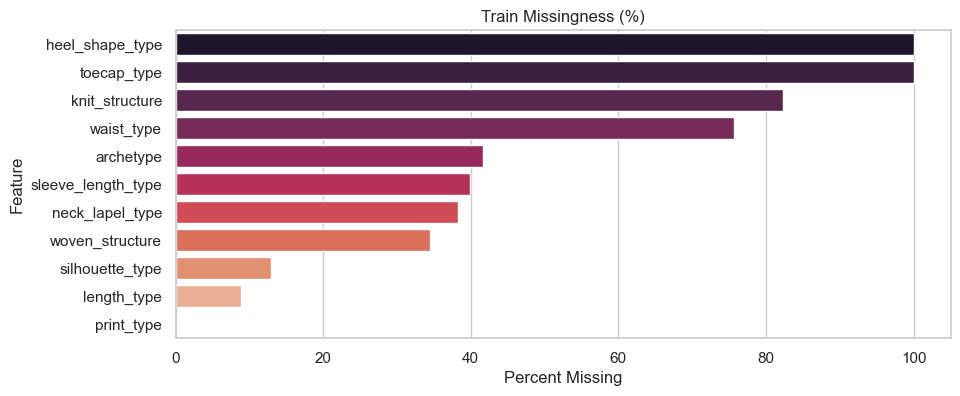

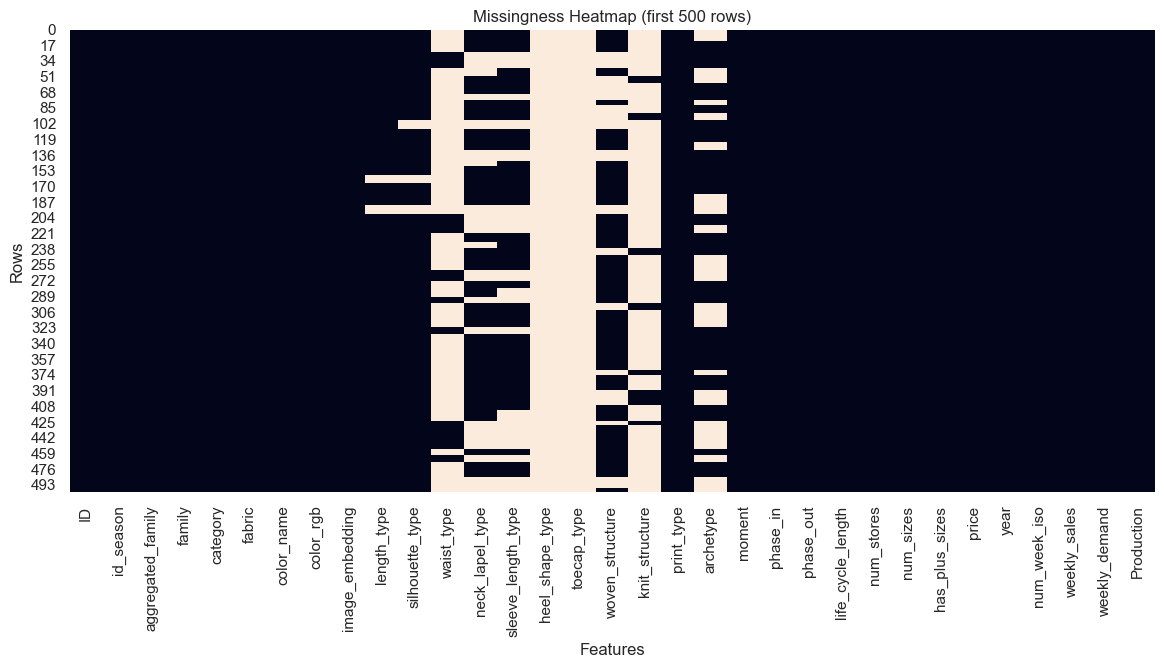

In [3]:
missing_pct = train_df.isna().mean().sort_values(ascending=False) * 100
missing_pct = missing_pct[missing_pct > 0]

if not missing_pct.empty:
    plt.figure(figsize=(10, max(4, len(missing_pct) * 0.2)))
    sns.barplot(x=missing_pct.values, y=missing_pct.index, palette="rocket")
    plt.title("Train Missingness (%)")
    plt.xlabel("Percent Missing")
    plt.ylabel("Feature")
    plt.show()
else:
    print("No missing values detected in train data.")

sample_for_heatmap = train_df.head(500).isna()
plt.figure(figsize=(14, 6))
sns.heatmap(sample_for_heatmap, cbar=False)
plt.title("Missingness Heatmap (first 500 rows)")
plt.xlabel("Features")
plt.ylabel("Rows")
plt.show()

## 3. Target Distribution Analysis & Outlier Flagging
Understand `Production` behavior via histograms/ECDF/boxplots, compute skew/kurtosis, and flag outliers via the IQR rule $Q_1 - 1.5\times IQR \le x \le Q_3 + 1.5\times IQR$ and z-score threshold $|z| \ge 3$.

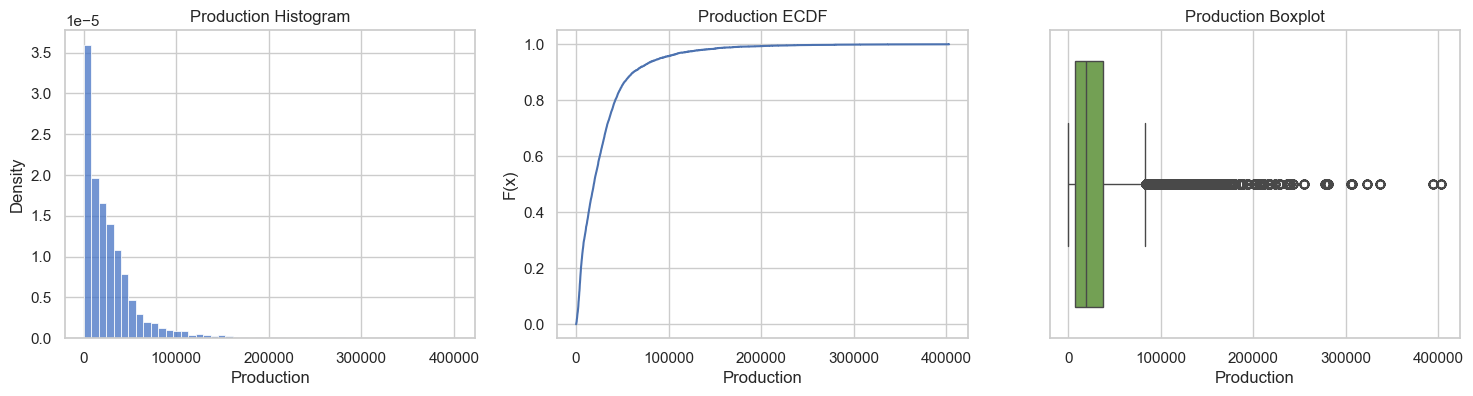

IQR bounds: -39139.00 to 83365.00
IQR outliers: 5678 (5.96%)
Z-score>=3 outliers: 2021 (2.12%)


In [4]:
target = train_df["Production"]
target_stats = {
    "mean": target.mean(),
    "median": target.median(),
    "std": target.std(),
    "skew": skew(target, nan_policy="omit"),
    "kurtosis": kurtosis(target, nan_policy="omit"),
}
target_stats

fig, axes = plt.subplots(1, 3, figsize=(18, 4))
sns.histplot(target, bins=50, ax=axes[0], color="#4472C4", stat="density")
axes[0].set_title("Production Histogram")

sorted_target = np.sort(target)
ecdf_y = np.arange(1, len(sorted_target) + 1) / len(sorted_target)
axes[1].plot(sorted_target, ecdf_y)
axes[1].set_title("Production ECDF")
axes[1].set_xlabel("Production")
axes[1].set_ylabel("F(x)")

sns.boxplot(x=target, ax=axes[2], color="#70AD47")
axes[2].set_title("Production Boxplot")
plt.show()

q1, q3 = np.percentile(target, [25, 75])
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
z_scores = zscore(target, nan_policy="omit")

iqr_outliers = (target < lower_bound) | (target > upper_bound)
z_outliers = np.abs(z_scores) >= 3

train_df["production_outlier_iqr"] = iqr_outliers
train_df["production_outlier_z3"] = z_outliers

print(f"IQR bounds: {lower_bound:.2f} to {upper_bound:.2f}")
print(f"IQR outliers: {iqr_outliers.sum()} ({iqr_outliers.mean() * 100:.2f}%)")
print(f"Z-score>=3 outliers: {np.sum(z_outliers)} ({np.mean(z_outliers) * 100:.2f}%)")

## 4. Numeric Feature Correlations & PCA Snapshot
Standardize numeric features, inspect Pearson/Spearman matrices, and capture variance via PCA component loadings.

c:\Users\sterr\Desktop\datathon2\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\sterr\Desktop\datathon2\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


num_stores           0.712734
weekly_sales         0.682236
weekly_demand        0.661472
num_sizes            0.615199
life_cycle_length    0.427749
price               -0.202173
num_week_iso        -0.027607
id_season            0.015698
ID                   0.011753
year                 0.005444
heel_shape_type           NaN
toecap_type               NaN
Name: Production, dtype: float64

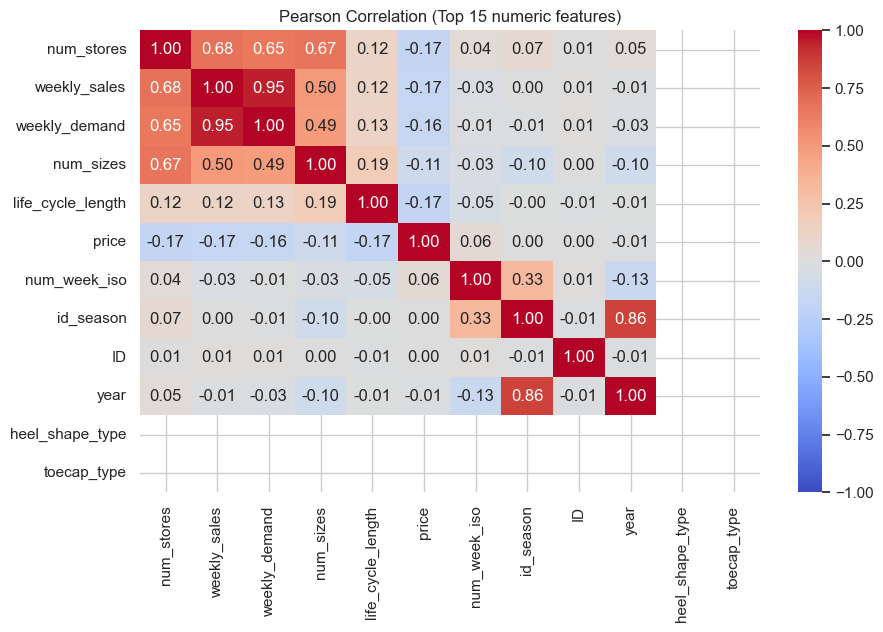

0    0.307350
1    0.189803
2    0.116237
3    0.101650
4    0.099817
5    0.084723
6    0.065343
7    0.026681
Name: explained_variance, dtype: float64

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
weekly_sales,0.517686,0.031179,0.084735,0.129470,0.009596,0.100699,0.406885,0.132006
weekly_demand,0.513382,0.019700,0.094180,0.117073,0.011645,0.089659,0.434936,0.176125
num_stores,0.488584,0.081533,0.095739,0.028871,0.016561,0.027856,0.334207,0.794012
num_sizes,0.427947,0.070572,0.023936,0.007257,0.023052,0.258096,0.665934,0.548280
price,0.156796,0.010370,0.474817,0.435249,0.089221,0.725863,0.148067,0.059569
life_cycle_length,0.143108,0.010225,0.487439,0.533237,0.059933,0.618512,0.254392,0.078582
year,0.028053,0.670239,0.242318,0.242539,0.021367,0.039981,0.052215,0.039012
id_season,0.020104,0.714522,0.063075,0.091247,0.009512,0.022035,0.008179,0.085582
num_week_iso,0.016955,0.163587,0.662207,0.651989,0.028457,0.044885,0.023061,0.043757
ID,0.006691,0.016639,0.099745,0.051199,0.993004,0.029962,0.012188,0.001812


In [13]:
numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
if "Production" in numeric_cols:
    numeric_cols.remove("Production")

numeric_df = train_df[numeric_cols].copy()
numeric_df = numeric_df.fillna(numeric_df.median())
numeric_df = numeric_df.fillna(0)
scaled_numeric = StandardScaler().fit_transform(numeric_df)

pearson_corr = pd.DataFrame(np.corrcoef(scaled_numeric, rowvar=False), index=numeric_cols, columns=numeric_cols)
spearman_corr = numeric_df.corr(method="spearman")

target_corr = train_df[numeric_cols + ["Production"]].corr()["Production"].drop("Production").sort_values(key=np.abs, ascending=False)
display(target_corr.head(15))

plt.figure(figsize=(10, 6))
sns.heatmap(pearson_corr.loc[target_corr.head(15).index, target_corr.head(15).index], annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Pearson Correlation (Top 15 numeric features)")
plt.show()

pca = PCA(n_components=min(8, len(numeric_cols)))
pca_components = pca.fit_transform(scaled_numeric)
explained = pd.Series(pca.explained_variance_ratio_, name="explained_variance")
display(explained)

loadings = pd.DataFrame(pca.components_.T, columns=[f"PC{i+1}" for i in range(pca.n_components_)], index=numeric_cols)
loadings.abs().sort_values("PC1", ascending=False).head(10)

## 5. Categorical Impact Study (Target Encoding Sketch)
Aggregate `Production` over high-cardinality categoricals, visualize top movers, and compute smoothed target encodings for future modeling.

Categorical columns (19): ['aggregated_family', 'family', 'category', 'fabric', 'color_name', 'color_rgb', 'image_embedding', 'length_type', 'silhouette_type', 'waist_type']...


C:\Users\sterr\AppData\Local\Temp\ipykernel_33352\959826484.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=agg, x="mean", y=col, palette="viridis")


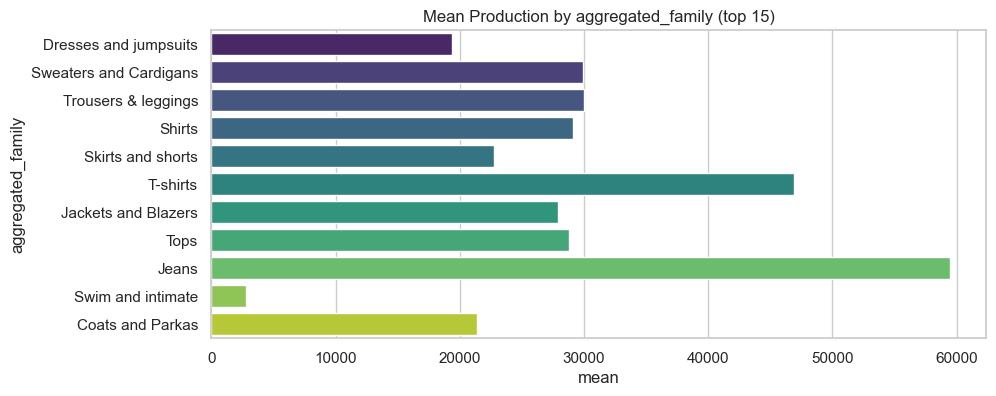

C:\Users\sterr\AppData\Local\Temp\ipykernel_33352\959826484.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=agg, x="mean", y=col, palette="viridis")


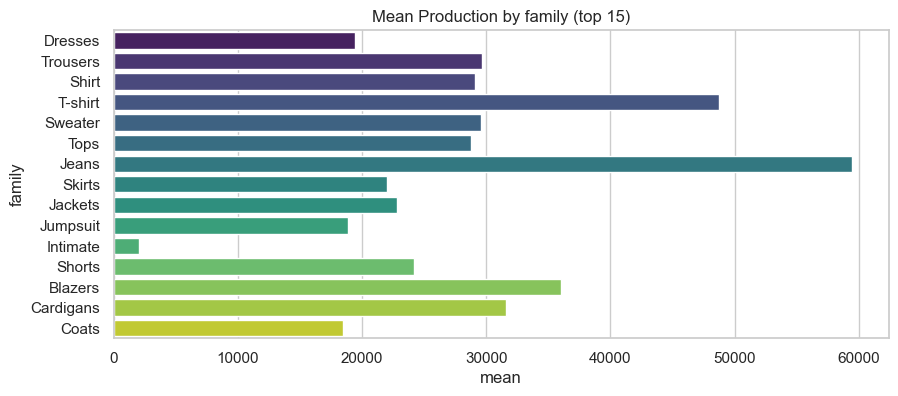

C:\Users\sterr\AppData\Local\Temp\ipykernel_33352\959826484.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=agg, x="mean", y=col, palette="viridis")


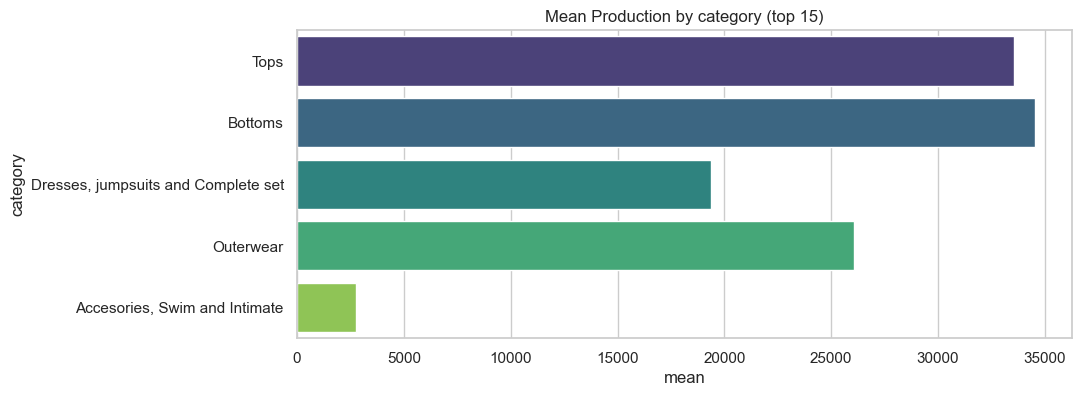

C:\Users\sterr\AppData\Local\Temp\ipykernel_33352\959826484.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=agg, x="mean", y=col, palette="viridis")


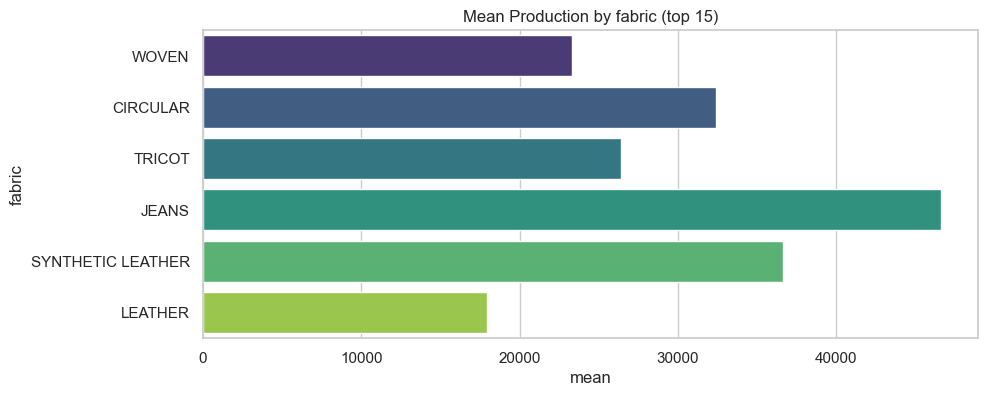

C:\Users\sterr\AppData\Local\Temp\ipykernel_33352\959826484.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=agg, x="mean", y=col, palette="viridis")


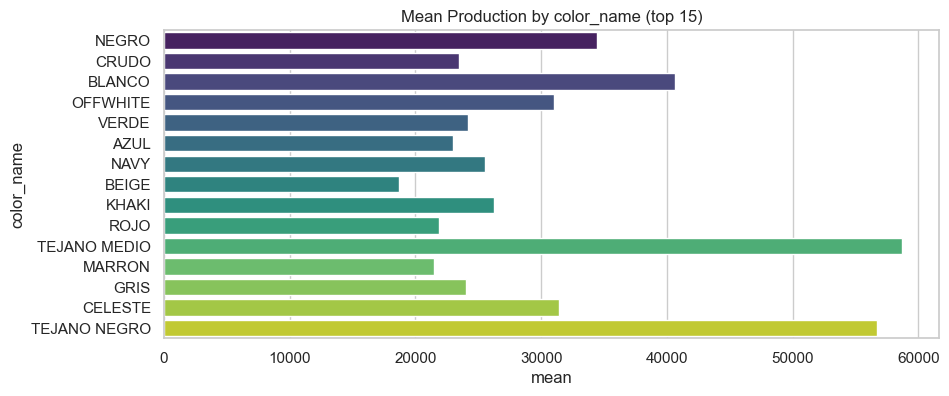

{'aggregated_family': aggregated_family
 Jeans                     58932.082360
 T-shirts                  46712.222965
 Trousers & leggings       29992.945558
 Sweaters and Cardigans    29867.895160
 Shirts                    29124.892342
 Tops                      28809.807600
 Jackets and Blazers       27931.529001
 Skirts and shorts         22781.160359
 Coats and Parkas          21570.056237
 Dresses and jumpsuits     19415.635692
 dtype: float64,
 'family': family
 Leather jackets         59544.227752
 Jeans                   58932.082360
 T-shirt                 48520.720636
 Leggings and joggers    36939.009837
 Blazers                 35754.478618
 Cardigans               31513.409852
 Trousers                29635.996163
 Sweater                 29590.678212
 Shirt                   29124.892342
 Tops                    28809.807600
 dtype: float64,
 'category': category
 Bottoms                                34528.053371
 Tops                                   33553.485401


In [7]:
categorical_cols = train_df.select_dtypes(include=["object", "category"]).columns.tolist()
print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols[:10]}{'...' if len(categorical_cols) > 10 else ''}")

def summarize_categorical(col: str, top_n: int = 15):
    agg = (
        train_df.groupby(col)["Production"]
        .agg(["count", "mean", "median", "std"])
        .sort_values("count", ascending=False)
        .head(top_n)
        .reset_index()
    )
    plt.figure(figsize=(10, 4))
    sns.barplot(data=agg, x="mean", y=col, palette="viridis")
    plt.title(f"Mean Production by {col} (top {top_n})")
    plt.show()
    return agg

cat_analyses = {}
for col in categorical_cols[:5]:
    cat_analyses[col] = summarize_categorical(col)

def smoothed_target_encoding(df: pd.DataFrame, col: str, target_col: str = "Production", m: int = 100):
    global_mean = df[target_col].mean()
    stats = df.groupby(col)[target_col].agg(["mean", "count"])
    smoothing = (stats["count"] * stats["mean"] + m * global_mean) / (stats["count"] + m)
    return smoothing

encoding_results = {}
for col in categorical_cols[:10]:
    smoothing = smoothed_target_encoding(train_df, col)
    encoding_results[col] = smoothing.sort_values(ascending=False).head(10)

encoding_results

## 6. Lifecycle & Temporal Feature Insights
Engineer date parts/lifecycle lengths, then inspect seasonal demand curves and production vs lifecycle duration.

,count,mean,median
launch_season,,,
Winter,19290,35220.747019,20914.0
Summer,23298,33381.224697,23790.0
Spring,26046,27197.811948,18901.0
Fall,26705,22182.857255,15771.0


C:\Users\sterr\AppData\Local\Temp\ipykernel_33352\2462360651.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=temporal, x="phase_in_month", y="Production", estimator="mean", ci=None, marker="o")


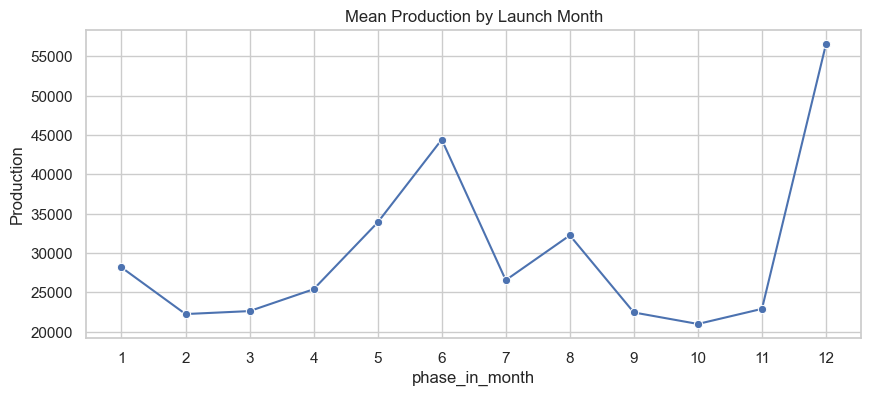

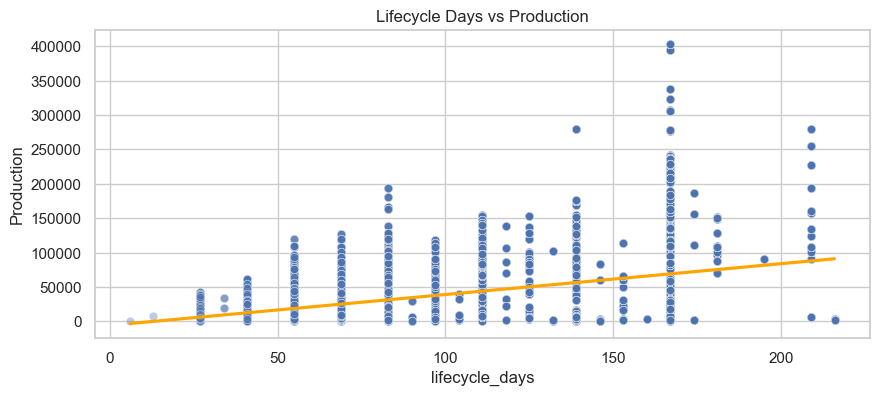

In [8]:
temporal = train_df.copy()
temporal["phase_in_dt"] = pd.to_datetime(temporal.get("phase_in"), format="%d/%m/%Y", errors="coerce")
temporal["phase_out_dt"] = pd.to_datetime(temporal.get("phase_out"), format="%d/%m/%Y", errors="coerce")
temporal["phase_in_month"] = temporal["phase_in_dt"].dt.month
temporal["phase_in_week"] = temporal["phase_in_dt"].dt.isocalendar().week.astype(float)
temporal["phase_in_weekday"] = temporal["phase_in_dt"].dt.weekday
temporal["lifecycle_days"] = (temporal["phase_out_dt"] - temporal["phase_in_dt"]).dt.days
temporal["lifecycle_days"] = temporal["lifecycle_days"].clip(lower=0)

season_map = {1: "Winter", 2: "Winter", 12: "Winter", 3: "Spring", 4: "Spring", 5: "Spring", 6: "Summer", 7: "Summer", 8: "Summer", 9: "Fall", 10: "Fall", 11: "Fall"}
temporal["launch_season"] = temporal["phase_in_month"].map(season_map)

season_summary = temporal.groupby("launch_season")["Production"].agg(["count", "mean", "median"]).sort_values("mean", ascending=False)
display(season_summary)

plt.figure(figsize=(10, 4))
sns.lineplot(data=temporal, x="phase_in_month", y="Production", estimator="mean", ci=None, marker="o")
plt.title("Mean Production by Launch Month")
plt.xticks(range(1, 13))
plt.show()

plt.figure(figsize=(10, 4))
sns.scatterplot(data=temporal, x="lifecycle_days", y="Production", alpha=0.2)
sns.regplot(data=temporal, x="lifecycle_days", y="Production", scatter=False, color="orange")
plt.title("Lifecycle Days vs Production")
plt.show()

## 7. Embedding Feature Diagnostics & Clustering
Reconstruct image embeddings, summarize distributions, project via PCA/UMAP proxy, and cluster to test whether visual groups explain Production variance.

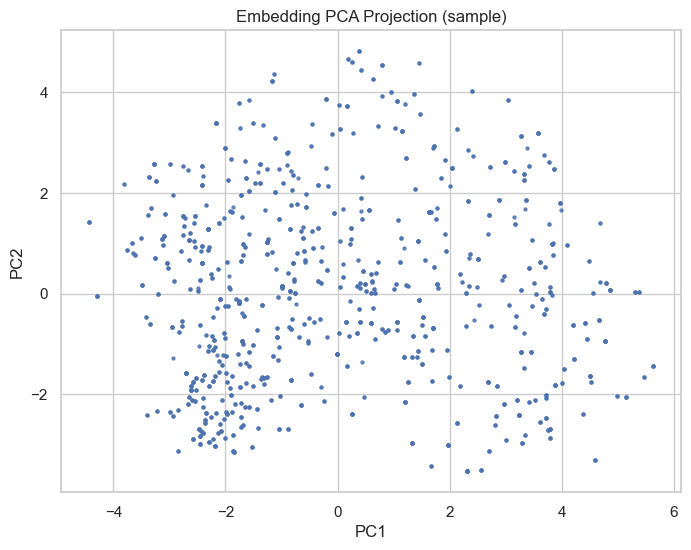

,count,mean,median,std
cluster,,,,
6,364,64511.395604,57116.0,47598.736439
3,1042,37023.107486,25542.0,44450.851487
5,732,31871.598361,19725.0,41955.922628
4,480,25129.175000,24558.0,17257.281047
2,696,22926.307471,19668.5,19770.015555
0,582,22647.391753,18641.0,18659.963087
7,558,21982.573477,10506.0,28493.427650
1,546,21269.615385,17075.0,18684.305888


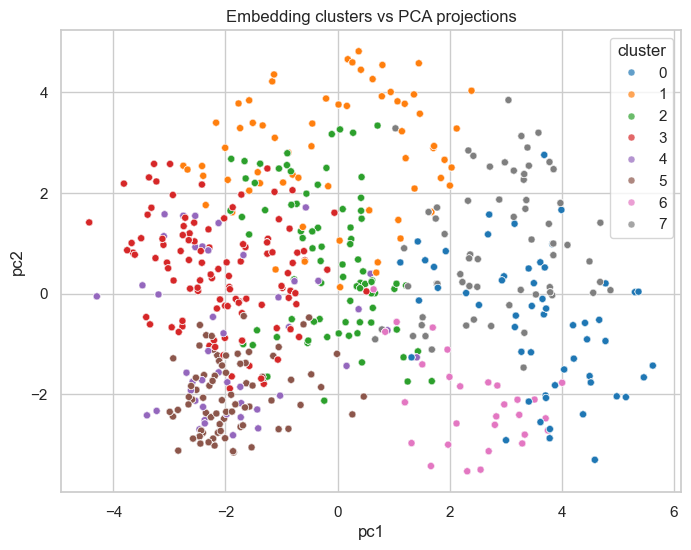

In [9]:
def parse_embedding(row_value: str) -> np.ndarray:
    if pd.isna(row_value) or row_value == "":
        return np.zeros(512, dtype=np.float32)
    try:
        values = [float(x) for x in str(row_value).split(",")]
        return np.array(values, dtype=np.float32)
    except Exception:
        return np.zeros(512, dtype=np.float32)

embedding_sample = train_df["image_embedding"].dropna().head(5000)
embedding_matrix = np.vstack(embedding_sample.apply(parse_embedding))

embedding_summary = pd.DataFrame({
    "mean": embedding_matrix.mean(axis=1),
    "std": embedding_matrix.std(axis=1),
    "max": embedding_matrix.max(axis=1),
    "min": embedding_matrix.min(axis=1),
})
embedding_summary.describe()

pca_embed = PCA(n_components=2, random_state=42).fit_transform(embedding_matrix)
plt.figure(figsize=(8, 6))
plt.scatter(pca_embed[:, 0], pca_embed[:, 1], s=4, alpha=0.3)
plt.title("Embedding PCA Projection (sample)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

cluster_count = 8
kmeans = KMeans(n_clusters=cluster_count, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(embedding_matrix)

cluster_df = pd.DataFrame({
    "cluster": cluster_labels,
    "Production": train_df.loc[embedding_sample.index, "Production"].values,
    "pc1": pca_embed[:, 0],
    "pc2": pca_embed[:, 1],
})
cluster_summary = cluster_df.groupby("cluster")["Production"].agg(["count", "mean", "median", "std"]).sort_values("mean", ascending=False)
display(cluster_summary)

plt.figure(figsize=(8, 6))
sns.scatterplot(data=cluster_df, x="pc1", y="pc2", hue="cluster", palette="tab10", s=25, alpha=0.7)
plt.title("Embedding clusters vs PCA projections")
plt.show()

## 8. Train/Test Drift & Leakage Queries
Compare train vs test distributions using KS-tests/PSI and sanity-check for leakage with suspicious correlations.

In [10]:
def population_stability_index(expected: pd.Series, actual: pd.Series, bins: int = 20) -> float:
    quantiles = np.linspace(0, 1, bins + 1)
    breakpoints = expected.quantile(quantiles).values
    breakpoints = np.unique(breakpoints)
    expected_hist, _ = np.histogram(expected, bins=breakpoints)
    actual_hist, _ = np.histogram(actual, bins=breakpoints)
    expected_pct = expected_hist / expected_hist.sum()
    actual_pct = actual_hist / actual_hist.sum()
    psi = np.sum((actual_pct - expected_pct) * np.log((actual_pct + 1e-6) / (expected_pct + 1e-6)))
    return psi

numeric_overlap = list(set(train_df.select_dtypes(include=[np.number]).columns) & set(test_df.select_dtypes(include=[np.number]).columns))
numeric_overlap = [col for col in numeric_overlap if col != "Production"]
drift_results = []
for col in numeric_overlap[:20]:
    train_col = train_df[col].dropna()
    test_col = test_df[col].dropna()
    if len(train_col) == 0 or len(test_col) == 0:
        continue
    ks_stat, ks_p = ks_2samp(train_col, test_col)
    psi_val = population_stability_index(train_col, test_col)
    drift_results.append({"feature": col, "ks_stat": ks_stat, "ks_pvalue": ks_p, "psi": psi_val})

drift_df = pd.DataFrame(drift_results).sort_values("psi", ascending=False)
display(drift_df.head(10))

print("Potential leakage audit: features with |corr| > 0.85 vs Production")
corr_candidates = train_df.select_dtypes(include=[np.number]).corr()["Production"].drop("Production").sort_values(key=np.abs, ascending=False)
display(corr_candidates[abs(corr_candidates) > 0.85])

C:\Users\sterr\AppData\Local\Temp\ipykernel_33352\2030216447.py:8: RuntimeWarning: invalid value encountered in divide
  actual_pct = actual_hist / actual_hist.sum()


,feature,ks_stat,ks_pvalue,psi
0,num_stores,0.107692,1.183445e-22,0.161165
2,price,0.088229,2.451391e-15,0.093328
5,life_cycle_length,0.095927,4.685243e-18,0.082010
4,num_sizes,0.090901,2.962844e-16,0.057465
3,ID,0.017497,5.058964e-01,0.006608
1,id_season,1.000000,0.000000e+00,NaN


Potential leakage audit: features with |corr| > 0.85 vs Production


Series([], Name: Production, dtype: float64)

## 9. Automated Feature Interaction Search
Scan pairwise ratios/products/polynomials to surface interactions that correlate strongly with `Production`.

In [11]:
from itertools import combinations

interaction_candidates = target_corr.head(8).index.tolist() if 'target_corr' in globals() else numeric_cols[:8]
interaction_scores = []
for col_a, col_b in combinations(interaction_candidates, 2):
    a = train_df[col_a]
    b = train_df[col_b]
    ratio = a / (b.replace(0, np.nan))
    product = a * b
    diff = a - b
    for feature_name, series in [(f"{col_a}_over_{col_b}", ratio), (f"{col_a}_times_{col_b}", product), (f"{col_a}_minus_{col_b}", diff)]:
        series = series.replace([np.inf, -np.inf], np.nan)
        corr_val = series.corr(train_df["Production"], method="spearman")
        interaction_scores.append({
            "feature": feature_name,
            "type": feature_name.split("_")[-1],
            "abs_corr": abs(corr_val),
            "corr": corr_val,
        })

interaction_df = pd.DataFrame(interaction_scores).dropna().sort_values("abs_corr", ascending=False).head(20)
interaction_df

,feature,type,abs_corr,corr
14,num_stores_minus_price,price,0.929587,0.929587
7,num_stores_times_num_sizes,sizes,0.924328,0.924328
18,num_stores_over_id_season,season,0.923072,0.923072
20,num_stores_minus_id_season,season,0.922578,0.922578
17,num_stores_minus_num_week_iso,iso,0.922525,0.922525
8,num_stores_minus_num_sizes,sizes,0.922027,0.922027
19,num_stores_times_id_season,season,0.921807,0.921807
10,num_stores_times_life_cycle_length,length,0.921114,0.921114
11,num_stores_minus_life_cycle_length,length,0.920338,0.920338
12,num_stores_over_price,price,0.909339,0.909339


## 10. Lightweight Model Probing for Error Hotspots
Fit a compact CatBoost model, inspect feature importances/SHAP-style scores, and analyze residual spikes to prioritize feature work.

Probe RMSE: 5003.53


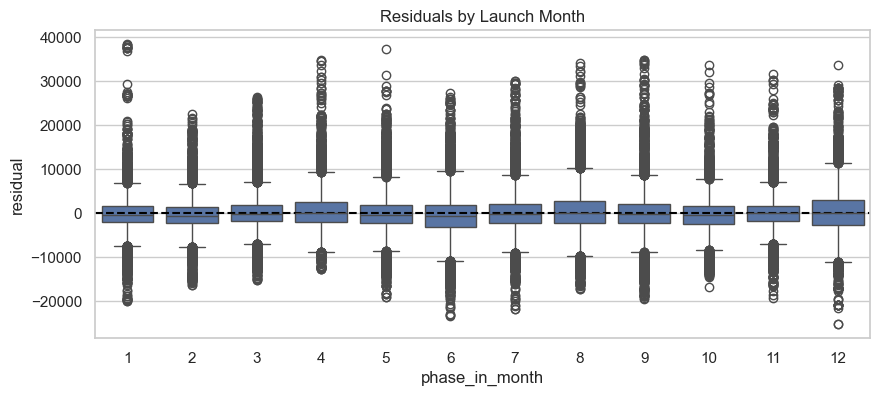

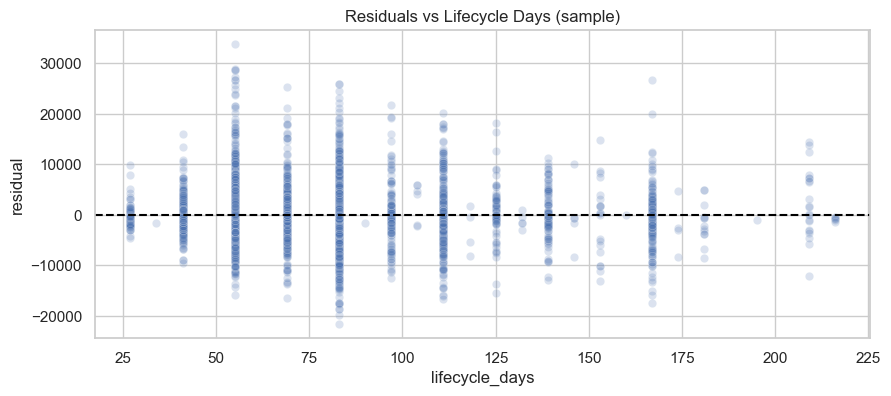

In [12]:
from catboost import CatBoostRegressor, Pool

feature_cols = [col for col in train_df.columns if col != "Production"]
X_basic = train_df[feature_cols].copy()
y_basic = train_df["Production"].astype(float)

cat_cols_basic = X_basic.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols_basic = X_basic.select_dtypes(include=[np.number]).columns.tolist()

for col in cat_cols_basic:
    X_basic[col] = X_basic[col].astype(str).fillna("missing")
X_basic[num_cols_basic] = X_basic[num_cols_basic].fillna(X_basic[num_cols_basic].median())

model_probe = CatBoostRegressor(
    iterations=400,
    depth=6,
    learning_rate=0.05,
    loss_function="RMSE",
    random_seed=42,
    verbose=False
)

pool = Pool(X_basic, y_basic, cat_features=[X_basic.columns.get_loc(c) for c in cat_cols_basic])
model_probe.fit(pool)

train_pred = model_probe.predict(pool)
residuals = y_basic - train_pred
rmse = np.sqrt(np.mean((residuals) ** 2))
print(f"Probe RMSE: {rmse:.2f}")

feature_importance_probe = pd.DataFrame({
    "feature": X_basic.columns,
    "importance": model_probe.get_feature_importance(pool, type="PredictionValuesChange"),
}).sort_values("importance", ascending=False)
feature_importance_probe.head(20)

residual_df = pd.DataFrame({
    "Production": y_basic,
    "prediction": train_pred,
    "residual": residuals,
    "phase_in_month": temporal.loc[train_df.index, "phase_in_month"],
    "lifecycle_days": temporal.loc[train_df.index, "lifecycle_days"],
})

plt.figure(figsize=(10, 4))
sns.boxplot(data=residual_df, x="phase_in_month", y="residual")
plt.axhline(0, color="black", linestyle="--")
plt.title("Residuals by Launch Month")
plt.show()

plt.figure(figsize=(10, 4))
sns.scatterplot(data=residual_df.sample(5000, random_state=42), x="lifecycle_days", y="residual", alpha=0.2)
plt.axhline(0, color="black", linestyle="--")
plt.title("Residuals vs Lifecycle Days (sample)")
plt.show()

## Next Steps & Feature Ideas
- Prioritize ratios involving demand, store count, and lifecycle (Section 9).
- Consider target encoding for `launch_season`, product category, and color clusters (Section 5 & 7).
- Address drifted numeric features flagged in Section 8 with distribution alignment or domain-specific scaling.
- Create embedding-cluster frequency features and combine with lifecycle buckets to capture visual-seasonal interactions.
- Use residual hotspots (Section 10) to design custom multipliers or hierarchical models for months with chronic bias.